# Modeling Process With Experimental Feature Database

In this notebook we use our experimental database to identify key features and tune the hyperparameters of several high preforming models. For model selection, we where looking for models where we could best improve the precision(reduce false positives) while not drastically reducing recall (false negatives).  To evaluate the models we used sklearn metrics and also viewed the confusion matrix to see how the models predictions on the test set preformed.

In [1]:
# Import Packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


# Sklearn Packages
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier


from sklearn import set_config
from sklearn import metrics
from sklearn.metrics import mean_squared_error, precision_score, confusion_matrix, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.exceptions import ConvergenceWarning
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from xgboost import plot_importance

set_config(print_changed_only=False)

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 300)
% matplotlib inline

plt.style.use('seaborn')

In [2]:
# Importing all functions used in this notebook
from functions import *

In [3]:
#Read in dataframe
df = pd.read_csv('experiment_features.csv',index_col=0)
df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_mode,histogram_mean,histogram_median,histogram_variance,fetal_health,uterine_cont_per_min,total_change,sqrt_total_change,hist_zeros_1.0,hist_zeros_2.0,hist_zeros_3.0,hist_zeros_4.0,hist_zeros_5.0,hist_zeros_7.0,hist_zeros_8.0,hist_zeros_10.0,hist_tendancy_0.0,hist_tendancy_1.0,sev_decel_0.001,quant_acc_1,quant_light_dec_1,quant_hist_mean_1,quant_hist_mean_2,quant_hist_mean_3,quant_hist_mean_4,quant_hist_mean_5,quant_hist_mean_6
0,120.0,0.000,0.0,0.000,0.000,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,120.0,137.0,121.0,73.0,2.0,0.00,0.000,0.000000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1,132.0,0.006,0.0,0.006,0.003,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,141.0,136.0,140.0,12.0,1.0,0.36,1.980,0.122474,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,133.0,0.003,0.0,0.008,0.003,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,141.0,135.0,138.0,13.0,1.0,0.48,1.862,0.118322,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,134.0,0.003,0.0,0.008,0.003,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,137.0,134.0,137.0,13.0,1.0,0.48,1.876,0.118322,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,132.0,0.007,0.0,0.008,0.000,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,137.0,136.0,138.0,11.0,1.0,0.48,1.980,0.122474,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0


In [4]:
# # Function Prints best parameters for GridSearchCV
# def print_results(results):
#     print('Best Parameters: {}\n'.format(results.best_params_))   

In [14]:
#train test split of data
X = df.drop('fetal_health', axis =1)
y = df.fetal_health

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=1)

In [15]:
#standared scaler for predicting features
scaler = StandardScaler()  
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

## Class imbalance

- To handle class imbalance we oversampled the minority class using SMOTE(Synthetic Minority Oversampling Technique), this balanced the minority class by sampling the nearest neighboors and adding points between the neighbors.  We used both a SMOTE sampled database and unbalanced database to compare the effect of the metrics for each experimental baseline model.  The Smote Database preformed better on every baseline model, we chose to use the SMOTE database for our final models.  

In [16]:
#Used smote to oversample minority class
smote = SMOTE(random_state=25)
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)

## KNN 

- Here we ran a basline model of knn on the experimental database and compared the metrics results to the database treated with smote.  


### Baseline KNN

In [27]:
#baseline KNN with class imbalance
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [28]:
#prediction metrics and confusion matrix of base KNN with class imbalance
evaluation(y_test, y_pred)

Evaluation Metrics:
Accuracy: 0.9191729323308271
Precision: 0.9236111111111112
Recall: 0.9755501222493888
F1 Score: 0.9488703923900119

Confusion Matrix:
 TN,  FP, FN, TP
[399  10  33  90]


In [31]:
#Base KNN model with Smote oversampled class
sm_knn = KNeighborsClassifier()
sm_knn.fit(X_train_smote, y_train_smote)
y_pred_smote_knn = sm_knn.predict(X_test)

In [32]:
#Prediction metrics and confusion matrix of smote base KNN
evaluation(y_test, y_pred_smote_knn)

Evaluation Metrics:
Accuracy: 0.9078947368421053
Precision: 0.9477611940298507
Recall: 0.9315403422982885
F1 Score: 0.9395807644882861

Confusion Matrix:
 TN,  FP, FN, TP
[381  28  21 102]


SMOTE didn't improve the model.

## Logistic Regression Baseline Model

- Here are two Logistic regression Models comparing the effect of SMOTE on the metric scores.  SMOTE greatly improved the precision of the model, however Recall was greatly reduced.  While one of the aims for our project was to improve precision as best we can, too many false negatives are not ideal for the overal fetal mortality rate.  

In [33]:
#Fit Train set with Logistic Regression model
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

In [34]:
#Regression model evaluation metrics and confusion matrix
evaluation(y_test, y_pred)

Evaluation Metrics:
Accuracy: 0.8778195488721805
Precision: 0.9056603773584906
Recall: 0.9388753056234719
F1 Score: 0.921968787515006

Confusion Matrix:
 TN,  FP, FN, TP
[384  25  40  83]


In [36]:
smlr = LogisticRegression(solver='liblinear')
smlr.fit(X_train_smote,y_train_smote)
y_predsm = smlr.predict(X_test)

In [37]:
evaluation(y_test, y_predsm)

Evaluation Metrics:
Accuracy: 0.8853383458646616
Precision: 0.967741935483871
Recall: 0.8801955990220048
F1 Score: 0.9218950064020486

Confusion Matrix:
 TN,  FP, FN, TP
[360  49  12 111]


- Below is a table of feature coefficients for the Logistic Regression.  The greatest feature Coefficients are sqrt_total_change, quant_acc_1, quant_hist_mean(1 2 and 3) and tendancy_1.  All of these features are ones that we engineered.  Looking at what these features represent, for this model, the change in the rate of FHR and the average change in that rate seem to be the biggest factors for classifying fetal health.  We wanted to try and improve the Logistic regression by tuning the hyperparameters to improve both the recall and precision.  To attempt this we used a bagging classifer to train the logistic regression on multiple random samples and aggrigate the predictions to see how that effected the evaluation metrics.  

In [39]:
#Create a table of logistic regression coefficients and comparing the coefficients 
#of the SMOTE and inbalanced datasets
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",lr.coef_.transpose())

coef_table_2 = pd.DataFrame(list(X_train_smote.columns)).copy()
coef_table_2.insert(len(coef_table_2.columns),'sm_Coefs',smlr.coef_.transpose())

smote_vs_coef = pd.concat([coef_table,coef_table_2],axis=1)
smote_vs_coef.columns = ['features','Coefs','del','sm_Coefs']
del smote_vs_coef['del']
smote_vs_coef.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
features,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_var...,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_mode,histogram_mean,histogram_median,histogram_variance,uterine_cont_per_min,total_change,sqrt_total_change,hist_zeros_1.0,hist_zeros_2.0,hist_zeros_3.0,hist_zeros_4.0,hist_zeros_5.0,hist_zeros_7.0,hist_zeros_8.0,hist_zeros_10.0,hist_tendancy_0.0,hist_tendancy_1.0,sev_decel_0.001,quant_acc_1,quant_light_dec_1,quant_hist_mean_1,quant_hist_mean_2,quant_hist_mean_3,quant_hist_mean_4,quant_hist_mean_5,quant_hist_mean_6
Coefs,0.117174,-0.0040917,0.0108432,-0.0053203,-0.00221984,0.000806171,0.0699097,-0.715013,0.0372611,0.0319318,-0.0144669,0.00639082,-0.00807605,0.251932,-0.0210527,0.0316949,-0.157476,0.032656,-0.319218,0.0406248,-0.0494468,0.0646365,0.0201561,-0.00272192,0.0176237,-0.00225233,0,0.0110208,-0.000777236,-0.0765569,0.0919297,-0.00379458,-0.235999,-0.34457,-0.467502,-0.255169,-0.356305,0.0562109,0.42863,0.598199
sm_Coefs,0.112113,-0.224252,0.313262,-0.055485,-0.0363894,0.0445865,0.08435,-0.626913,0.0396073,0.0459468,-0.00961589,-0.0010398,-0.0106557,0.200837,-0.00977889,-0.0597073,-0.0313393,0.0454627,-3.3291,0.0622807,-1.24574,-0.514483,-0.583633,-1.0854,0.384853,-0.626686,0,0.195844,-0.629847,-0.752577,-1.25432,-0.238835,-3.31225,-1.66982,-2.73523,-2.34835,-2.62443,-1.19418,-0.1252,0.816205


In [40]:
# Bagging classifier for legistic regression
bag_log = BaggingClassifier(
    base_estimator=LogisticRegression(
        random_state=1),n_estimators=200,
    max_samples=.85,
    max_features=10,oob_score=True,
    n_jobs=-1,verbose=1)

In [42]:
# Fit bagging classifier
bag_log.fit(X_train_smote, y_train_smote)
y_pred = bag_log.predict(X_test)

# Evaluation Metrics
evaluation(y_test,y_pred)

[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.2s remaining:   12.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.2s finished


Evaluation Metrics:
Accuracy: 0.8759398496240601
Precision: 0.9549071618037135
Recall: 0.8801955990220048
F1 Score: 0.9160305343511449

Confusion Matrix:
 TN,  FP, FN, TP
[360  49  17 106]


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


- The Bagging classifer made only minute changes to the evaluation metrics.  We decided to look at some other models and compare the results.

## Decision Tree

- The next model we tried was a decision tree.  Again we compared the imbalanced and SMOTE data sets on baseline models to observe the effect on the metrics.  With the SMOTE data set, decision tree produced very good metrics with all default hyperparamers.  The most important features where abnormal_short_term_variability, and mean_value_of_short_term_variability	

In [43]:
#Train decision tree with train set and predict on the test set
tree = DecisionTreeClassifier()
tree = tree.fit(X_train,y_train)
y_pred = tree.predict(X_test)

In [44]:
#Evaluation metrics
evaluation(y_test, y_pred)

Evaluation Metrics:
Accuracy: 0.9229323308270677
Precision: 0.9577114427860697
Recall: 0.941320293398533
F1 Score: 0.9494451294697904

Confusion Matrix:
 TN,  FP, FN, TP
[385  24  17 106]


In [46]:
#Decision tree with smote dataset
smtree = DecisionTreeClassifier()
smtree.fit(X_train_smote,y_train_smote)
y_pred = smtree.predict(X_test)

In [47]:
#evaluation Metrics
evaluation(y_test, y_pred)

Evaluation Metrics:
Accuracy: 0.9342105263157895
Precision: 0.9583333333333334
Recall: 0.9559902200488998
F1 Score: 0.9571603427172583

Confusion Matrix:
 TN,  FP, FN, TP
[391  18  17 106]


In [49]:
#Table for decision tree feature coefficients
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",tree.feature_importances_.transpose())

coef_table_2 = pd.DataFrame(list(X_train_smote.columns)).copy()
coef_table_2.insert(len(coef_table_2.columns),'sm_Coefs',tree.feature_importances_.transpose())

smote_vs_coef = pd.concat([coef_table,coef_table_2],axis=1)
smote_vs_coef.columns = ['features','importance','del','sm_importance']
del smote_vs_coef['del']
smote_vs_coef.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
features,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_var...,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_mode,histogram_mean,histogram_median,histogram_variance,uterine_cont_per_min,total_change,sqrt_total_change,hist_zeros_1.0,hist_zeros_2.0,hist_zeros_3.0,hist_zeros_4.0,hist_zeros_5.0,hist_zeros_7.0,hist_zeros_8.0,hist_zeros_10.0,hist_tendancy_0.0,hist_tendancy_1.0,sev_decel_0.001,quant_acc_1,quant_light_dec_1,quant_hist_mean_1,quant_hist_mean_2,quant_hist_mean_3,quant_hist_mean_4,quant_hist_mean_5,quant_hist_mean_6
importance,0.0417007,0.0196927,0.0129526,0.00915159,0,0.0285847,0.342457,0.117288,0.0467433,0.0120976,0.0193758,0.0326662,0.0351468,0.0132994,0.0228727,0.168744,0.00889406,0.00628032,0.00526129,0.0384527,0.0126355,0.000779075,0,0,0.00361421,0,0,0,0,0,0.00130948,0,0,0,0,0,0,0,0,0
sm_importance,0.0417007,0.0196927,0.0129526,0.00915159,0,0.0285847,0.342457,0.117288,0.0467433,0.0120976,0.0193758,0.0326662,0.0351468,0.0132994,0.0228727,0.168744,0.00889406,0.00628032,0.00526129,0.0384527,0.0126355,0.000779075,0,0,0.00361421,0,0,0,0,0,0.00130948,0,0,0,0,0,0,0,0,0


## Random Forest

- As we did above we used the SMOTE and imbalanced data and this time trained a random forest classifer.  


In [50]:
#Random Forest classifier using 50 estimators and a max depth of 3
rfc = RandomForestClassifier(random_state =1, n_estimators= 50, max_depth = 3, n_jobs =-1,verbose=1)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


In [51]:
#Evaluation metrics for random forest
evaluation(y_test, y_pred)

Evaluation Metrics:
Accuracy: 0.900375939849624
Precision: 0.8973214285714286
Recall: 0.9828850855745721
F1 Score: 0.9381563593932323

Confusion Matrix:
 TN,  FP, FN, TP
[402   7  46  77]


In [54]:
#Random Forest classifier using 50 estimators and a max depth of 3 using SMOTE dataset
smrfc = RandomForestClassifier(random_state =1, n_estimators= 50, max_depth = 3, n_jobs =-1,verbose=1)
smrfc.fit(X_train_smote,y_train_smote)
y_pred = smrfc.predict(X_test)

evaluation(y_test, y_pred)

Evaluation Metrics:
Accuracy: 0.9116541353383458
Precision: 0.9547738693467337
Recall: 0.9290953545232273
F1 Score: 0.9417596034696406

Confusion Matrix:
 TN,  FP, FN, TP
[380  29  18 105]


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


In [56]:
#Create table of feature coefficients
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",rfc.feature_importances_.transpose())

coef_table_2 = pd.DataFrame(list(X_train_smote.columns)).copy()
coef_table_2.insert(len(coef_table_2.columns),'sm_Coefs',smrfc.feature_importances_.transpose())

smote_vs_coef = pd.concat([coef_table,coef_table_2],axis=1)
smote_vs_coef.columns = ['features','importance_baseline','del','sm_importance_baseline']
del smote_vs_coef['del']
smote_vs_coef.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
features,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_var...,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_mode,histogram_mean,histogram_median,histogram_variance,uterine_cont_per_min,total_change,sqrt_total_change,hist_zeros_1.0,hist_zeros_2.0,hist_zeros_3.0,hist_zeros_4.0,hist_zeros_5.0,hist_zeros_7.0,hist_zeros_8.0,hist_zeros_10.0,hist_tendancy_0.0,hist_tendancy_1.0,sev_decel_0.001,quant_acc_1,quant_light_dec_1,quant_hist_mean_1,quant_hist_mean_2,quant_hist_mean_3,quant_hist_mean_4,quant_hist_mean_5,quant_hist_mean_6
importance_baseline,0.00992676,0.103532,0.00470882,0.0105892,0.00061708,0.0876404,0.157685,0.149226,0.0898387,0.0122778,0.0241374,0.0345421,0.00347558,0.00129207,0.0299309,0.100239,0.0523094,0.0412711,0.0316257,0.0267606,0.0168846,0.000475167,0,0,0,0,0,0,0,0,0.000412919,0,0.0050735,0.00202451,6.36107e-07,0,0.000271607,0.000183496,0.000962509,0.00208523
sm_importance_baseline,0.0172741,0.20107,0.00249253,0.0203137,0.00140923,0.0858243,0.173725,0.104371,0.0807028,0.00967133,0.0139368,0.0450373,0.007946,0.000497999,0.0139928,0.0629823,0.0220239,0.0390045,0.0415174,0.0158197,0.00860188,0,0,0,0,0,0,0,0,0,0,0,0.0241652,0.000976957,0.000289048,0.000687007,0.00428605,0,0.000333931,0.00104688


## Grid Search Random Forest
- We ran a gridsearch on the random forest to identify what the best hyperparamters where for the model.  We checked several estimator sizes, max depth and min weight fraction leaf to find the ideal parameters.  

In [57]:
#parameter grid for grid search with lists of estimators, both criterion, a list of max depths sqrt max features 
#and a list of min weight fraction leaf
parameters = {
    'n_estimators': [25,50,100,300,500],
    'criterion' : ['gini','entropy'],
    'max_depth' : [8,9,10,11,12],
    'max_features' : ['sqrt'],
    'min_weight_fraction_leaf' : [0,0.1,0.3,0.5],
}

In [58]:
#Gridsearch with random forest
grid_tree=GridSearchCV(RandomForestClassifier(), parameters, cv=15, scoring='f1', verbose=1, n_jobs=-1)

In [59]:
# Fit random forest grid serch to SMOTE train set
grid_tree.fit(X_train_smote, y_train_smote)

Fitting 15 folds for each of 200 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  8.6min finished


GridSearchCV(cv=15, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [60]:
# Find the best score, best parameters and best estimator for grid search
print(grid_tree.best_score_)
print()
print(grid_tree.best_params_)
print()
print(grid_tree.best_estimator_)

0.9753981661884176

{'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'min_weight_fraction_leaf': 0, 'n_estimators': 50}

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0, n_estimators=50, n_jobs=None,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


In [61]:
# Evaluation metrics for random forest gridsearch best parameters
y_pred = grid_tree.best_estimator_.predict(X_test)
evaluation(y_test,y_pred)

Evaluation Metrics:
Accuracy: 0.9586466165413534
Precision: 0.9662650602409638
Recall: 0.980440097799511
F1 Score: 0.9733009708737864

Confusion Matrix:
 TN,  FP, FN, TP
[401   8  14 109]


**Findings:** 
- The best parameters for the random forest was a max depth of 11, min weight fraction leave of 0, and 500 estimators.  The Evaluation metrics where our highest score with the experimental set so far.  Below we compared feature importance for the three random forest models we ran and then graphed the top ten important features to visualize there importance for fetal health classification.

In [62]:
# Best feature table for random forest gridsearch best parameters
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",grid_tree.best_estimator_.feature_importances_.transpose())
coef_table.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_var...,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_mode,histogram_mean,histogram_median,histogram_variance,uterine_cont_per_min,total_change,sqrt_total_change,hist_zeros_1.0,hist_zeros_2.0,hist_zeros_3.0,hist_zeros_4.0,hist_zeros_5.0,hist_zeros_7.0,hist_zeros_8.0,hist_zeros_10.0,hist_tendancy_0.0,hist_tendancy_1.0,sev_decel_0.001,quant_acc_1,quant_light_dec_1,quant_hist_mean_1,quant_hist_mean_2,quant_hist_mean_3,quant_hist_mean_4,quant_hist_mean_5,quant_hist_mean_6
Coefs,0.0253198,0.111056,0.0133262,0.0272228,0.00884189,0.0499036,0.167461,0.090732,0.0614142,0.0280673,0.0213656,0.0337478,0.0202811,0.0143864,0.0390797,0.0669102,0.0514727,0.0465844,0.036311,0.0209053,0.0227478,0.00083542,0.000683196,0.000339523,0.000314223,0,0,0,0,0.00280929,0.00294722,0.000320958,0.0175078,0.00272703,0.00347671,0.00196887,0.0027366,0.00110818,0.0016362,0.00345193


In [63]:
# Table comparing random forest best features between imbalanced data set, smote and smote with gridsearch best features
coef_table.columns = ['features','grid_search_importance']
del coef_table['features']
best_features_rfc = pd.concat([smote_vs_coef,coef_table],axis=1)

In [64]:
best_features_rfc.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
features,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_var...,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_mode,histogram_mean,histogram_median,histogram_variance,uterine_cont_per_min,total_change,sqrt_total_change,hist_zeros_1.0,hist_zeros_2.0,hist_zeros_3.0,hist_zeros_4.0,hist_zeros_5.0,hist_zeros_7.0,hist_zeros_8.0,hist_zeros_10.0,hist_tendancy_0.0,hist_tendancy_1.0,sev_decel_0.001,quant_acc_1,quant_light_dec_1,quant_hist_mean_1,quant_hist_mean_2,quant_hist_mean_3,quant_hist_mean_4,quant_hist_mean_5,quant_hist_mean_6
importance_baseline,0.00992676,0.103532,0.00470882,0.0105892,0.00061708,0.0876404,0.157685,0.149226,0.0898387,0.0122778,0.0241374,0.0345421,0.00347558,0.00129207,0.0299309,0.100239,0.0523094,0.0412711,0.0316257,0.0267606,0.0168846,0.000475167,0,0,0,0,0,0,0,0,0.000412919,0,0.0050735,0.00202451,6.36107e-07,0,0.000271607,0.000183496,0.000962509,0.00208523
sm_importance_baseline,0.0172741,0.20107,0.00249253,0.0203137,0.00140923,0.0858243,0.173725,0.104371,0.0807028,0.00967133,0.0139368,0.0450373,0.007946,0.000497999,0.0139928,0.0629823,0.0220239,0.0390045,0.0415174,0.0158197,0.00860188,0,0,0,0,0,0,0,0,0,0,0,0.0241652,0.000976957,0.000289048,0.000687007,0.00428605,0,0.000333931,0.00104688
grid_search_importance,0.0253198,0.111056,0.0133262,0.0272228,0.00884189,0.0499036,0.167461,0.090732,0.0614142,0.0280673,0.0213656,0.0337478,0.0202811,0.0143864,0.0390797,0.0669102,0.0514727,0.0465844,0.036311,0.0209053,0.0227478,0.00083542,0.000683196,0.000339523,0.000314223,0,0,0,0,0.00280929,0.00294722,0.000320958,0.0175078,0.00272703,0.00347671,0.00196887,0.0027366,0.00110818,0.0016362,0.00345193


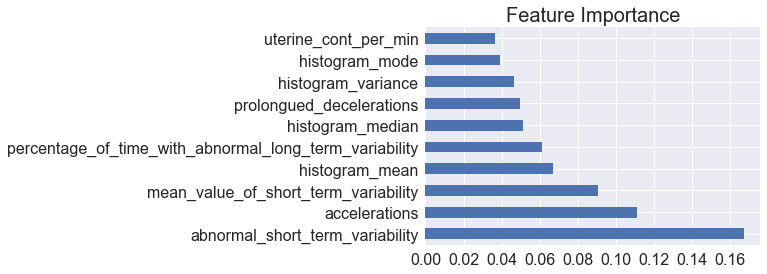

In [65]:
pd.Series(grid_tree.best_estimator_.feature_importances_, index=X.columns).nlargest(10).plot(kind='barh')
plt.title('Feature Importance', fontsize=20)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.show()

**findings**
- In the Above graphe you can see the top ten importanct features for our grid search random foret model.  Abnormal_short_term_variatability, acceleration and mean_value_of_short_term_varitability seem to be key factors in health classification.  We can infer from this that extended rapid extreme changes in fetal heart rate are detrimental to fetal health.

## XGboost

- We wanted to try an XGboost classifer to attempt a better model than the gridsearch random forest.  XGboost uses gradiant descent and boosting principles to regression trees.  We first tried an XGboost model with some parametrs we thought would be ideal for the model.  Next we ran a grid search on the XGboost parameters to produce our best possible model.  

In [66]:
xgb.XGBClassifier()

<IPython.core.display.Javascript object>

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, use_label_encoder=True,
              validate_parameters=None, verbosity=None)

In [70]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree = 0.75, 
                           subsample = 0.85,
                           learning_rate = 0.1,
                           max_depth = 11, 
                           alpha = 1, 
                           n_estimators = 1000,
                          verbose=1, n_jobs=-1)

<IPython.core.display.Javascript object>

In [74]:
# Checking if XGBoost is in the correct version
xgb.__version__

<IPython.core.display.Javascript object>

'1.3.0'

It's known that the 1.3.0 version has problems. I need to update it.

In [73]:

xg_clf.fit(X_train, y_train)

AttributeError: dlsym(0x7ff7747d59b0, XGDMatrixSetDenseInfo): symbol not found

In [72]:
y_pred = xg_clf.predict(X_test)

AttributeError: dlsym(0x7ff7747d59b0, XGDMatrixSetStrFeatureInfo): symbol not found

In [ ]:
evaluation(y_test,y_pred)

In [ ]:
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",xg_clf.feature_importances_.transpose())

In [ ]:
coef_table

In [ ]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': [500,1000,1500],
              'learning_rate': [0.1,0.07,0.05,0.03,0.01],
              'max_depth': [9,10,11,12,13],
              'colsample_bytree': [0.5,0.45,0.4],
              'min_child_weight': [1, 2, 3]
             }

In [ ]:
grid_xg = GridSearchCV(estimator=clf_xgb,
                      param_grid= param_dist,
                      scoring='f1',
                      n_jobs=-1,
                      verbose=1,
                      iid=False,
                      cv=10)

In [ ]:
grid_xg.fit(smX_train,smy_train)

In [ ]:
grid_xg.best_params_

In [ ]:
y_pred = grid_xg.best_estimator_.predict(X_test)

In [ ]:
evaluation(y_test,y_pred)

In [ ]:
from xgboost import plot_importance
plot_importance(grid_xg.best_estimator_)

In [ ]:
plot_importance(grid_xg.best_estimator_,max_num_features=10)

**findings**
- The grid search xgboost produced our overall best model.  We where extremely pleased with the highest recall and accuracy score.  The precision, which was our target metric was also very high.  When graphing the featrue importance, the most important features where abnormal_short_term_variatability and the histogram mean, min, width  and mode.  Our engineered features where not as important as some of the unchanged features.  Our best preforming engineered feature was sqrt_total_change, but no engineered feature was in the top ten.  Just like our random forest model short term varitability of the FHR is a key feature in classifying fetal health.